# 贫瘠高原

## 概述

贫瘠高原是一大类随机参数化量子电路（PQC）的基于梯度的优化中最大的困难。 渐变几乎无处不在。 在此示例中，我们将展示量子神经网络 (QNN) 中的贫瘠高原。

## 设置

In [1]:
import numpy as np
import tensorflow as tf
import tensorcircuit as tc

tc.set_backend("tensorflow")
tc.set_dtype("complex64")

Rx = tc.gates.rx
Ry = tc.gates.ry
Rz = tc.gates.rz

## 参数

In [2]:
n = 4  # 量子比特的数量
nlayers = 1  # 电路的层数
ncircuits = 3  # 有不同初始参数的电路数量
ntrials = 2  # 有不同结构的随机电路数量

## 产生 QNN

In [3]:
def op_expectation(params, seed, n, nlayers):
    paramsc = tc.backend.cast(params, dtype="float32")  # 门的参数
    seedc = tc.backend.cast(seed, dtype="float32")  # 电路结构的参数

    c = tc.Circuit(n)
    for i in range(n):
        c.ry(i, theta=np.pi / 4)
    for l in range(nlayers):
        for i in range(n):
            # 从 Rx、Ry 和 Rz 门中选择一个具有相等概率 = 1/3 的门； 状态是种子。
            c.unitary_kraus(
                [Rx(paramsc[i, l]), Ry(paramsc[i, l]), Rz(paramsc[i, l])],
                i,
                prob=[1 / 3, 1 / 3, 1 / 3],
                status=seedc[i, l],
            )
        for i in range(n - 1):
            c.cz(i, i + 1)

    return tc.backend.real(
        c.expectation((tc.gates.z(), [0]), (tc.gates.z(), [1]))
    )  # <Z_0Z_1> 的期望

In [4]:
# 使用 vmap 和 vvag 获得 ZZ 可观察的期望值和不同随机电路实例的梯度
op_expectation_vmap_vvag = tc.backend.jit(
    tc.backend.vmap(
        tc.backend.vvag(op_expectation, argnums=0, vectorized_argnums=0),
        vectorized_argnums=1,
    )
)

## 批量方差计算

In [5]:
seed = tc.array_to_tensor(
    np.random.uniform(low=0.0, high=1.0, size=[ntrials, n, nlayers]), dtype="float32"
)
params = tc.array_to_tensor(
    np.random.uniform(low=0.0, high=2 * np.pi, size=[ncircuits, n, nlayers]),
    dtype="float32",
)

e, grad = op_expectation_vmap_vvag(
    params, seed, n, nlayers
)  # 不同随机电路的 ZZ 可观测量和梯度的期望

grad_var = tf.math.reduce_std(tf.math.reduce_std(grad, axis=0), axis=0)[
    0, 0
]  # 第一个参数的梯度方差
print("The variance of the gradients is:", grad_var.numpy())

The variance of the gradients is: 0.19805922


## 结果

QNN 中的梯度方差（$nlayers=50$，$ntrials=20$，$ncircuits=20$）。 随着量子比特数量的增加，景观变得指数级贫瘠。

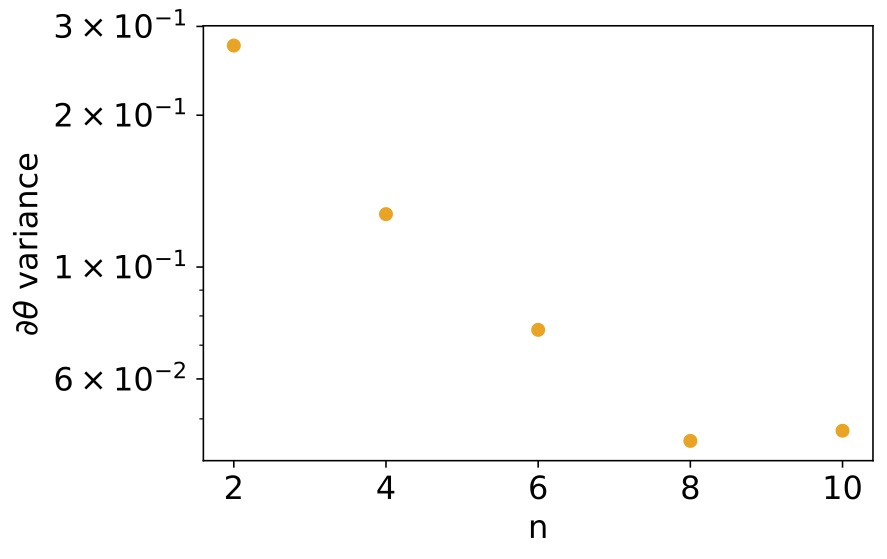